# Modelo GEN 1M

Las peliculas se codifican mediante su vector de generos de partida, de tal forma que solo podrá tener ceros y unos. 
lo que dotará al sistema de poca flexibilidad al hacer el producto escalar. 

En este caso, Los usuarios se codificaran por one hot y las peliculas se codificarán mediante el vector de generos a los que pertenecen

Se preprocesa el cojunto de datos para agilizar las ejecuciones. 

#### Resultados en el modelo 1M
  
    rectificado error en preprocesado 
- Test                         loss:   2.4554

- Test             MAE sobre scores: 1.2680



In [4]:
import pickle
import pandas as pd
from math import pi
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf

 
#garantizamos mismos resultados entre ejecuciones
import os
os.environ['PYTHONHASHSEED']='0'
rs = 1234  # Semilla aleatoria
np.random.seed(rs)
tf.random.set_seed(rs)

In [5]:
def save_to_pickle(name, item):
    filehandler = open(name+".pkl", "wb")
    pickle.dump(item, filehandler)
    filehandler.close()


def plot_metric(history, metric, valida):
    train_metrics = history.history[metric]
    # if valida:
    #    val_metrics = history.history['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics)
    if valida:
        val_metrics = history.history['val_' + metric]
        plt.plot(epochs, val_metrics)
        plt.title('Training and validation ' + metric)
    else:
        plt.title('Training ' + metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    if valida:
        plt.legend(["train_"+metric, 'val_' + metric])
    plt.show()

In [6]:
def crear_modelo(K, LR, num_users, num_pelis, dim_users, dim_pelis, peso_score):
    user_input = tf.keras.layers.Input(shape=(dim_users,), name="input_usr")  # Variable-length sequence of ints
    usuarios_emb = tf.keras.layers.Embedding(input_dim=num_users, output_dim=K, name="embedding_usr")(user_input)
    usuarios = tf.keras.layers.Flatten(name="flatten_usr")(usuarios_emb)  # para pasar de (?,1,K) a (?,K)
    usr_emb_genr = tf.keras.layers.Dense(num_genres, activation='relu', name="usr_dot")(usuarios)  # (?, num_genres)

    pelis_input = tf.keras.layers.Input(shape=(dim_pelis,), name="input_pelis")  # Variable-length sequence of ints
    # pelis_emb = tf.keras.layers.Embedding(input_dim=num_pelis, output_dim=K, name="embedding_pelis")(pelis_input)
    # pelis = tf.keras.layers.Flatten(name="flatten_pelis")(pelis_emb)  # para pasar de (?,1,K) a (?,K)
    # genre_pred = tf.keras.layers.Dense(num_genres, activation='sigmoid', name="genres")(pelis)  # (?, num_genres)

    score_pred = tf.keras.layers.Dot(axes=1, name="scores")([usr_emb_genr, pelis_input])

    model = tf.keras.Model(
        inputs=[user_input, pelis_input],
        outputs=[score_pred],
    )

    model.compile(
        optimizer=tf.keras.optimizers.Adam(LR),
        # optimizer=keras.optimizers.RMSprop(1e-3),
        loss=tf.keras.losses.MeanSquaredError(),
        # loss_weights=[peso_score, 1 - peso_score],
        metrics=['mean_absolute_error'],  # tf.keras.metrics.BinaryAccuracy()],
    )

    model_usr = tf.keras.Model(
        inputs=[user_input],
        outputs=[usr_emb_genr],
    )

    '''model2.summary()
    output_array2 = model2.predict([valoraciones.user_id, valoraciones.item_id])
    print(output_array2.shape)'''

    return model, model_usr

In [7]:
def entrenar(VALIDATION, K, epochs, batch_size, learning_rate, peso_score, num_users, num_pelis, dim_input_users,
             dim_input_pelis, X_train, X_train_dev, X_test, y_train, y_train_dev, y_test):
    # SE CREA EL MODELO
    model, mod_usr = crear_modelo(K, learning_rate, num_users, num_pelis, dim_input_users, dim_input_pelis, peso_score)

    # ENTRENAMOS EL MODELO Y EVALUAMOS EN EL CONJUNTO DE TEST
    if VALIDATION:
        # DECLARAMOS UN OBJETO EARLY STOPPING PARA DECIDIR LA MEJOR EPOCH
        early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
        csv_logger = tf.keras.callbacks.CSVLogger("model/model_history_generos_reales_log.csv", append=True)
        checkpoint = tf.keras.callbacks.ModelCheckpoint('model/model_genREal25_{epoch:06d}.h5', save_best_only=True)
        
        history = model.fit(x=[X_train.user_id, X_train[col_items]], y=[y_train],
                            validation_data=([X_dev.user_id, X_dev[col_items]], [y_dev]),
                            epochs=epochs, batch_size=batch_size, callbacks=[early_stop, checkpoint,csv_logger])
        print('Mejor epoch:', early_stop.stopped_epoch)
        media_en_train = y_train.mean()
    else:
        if epochs == 0:
            epochs = 1000
        checkpoint = tf.keras.callbacks.ModelCheckpoint('model/model_history_generos_reales2_log.csv')
        csv_logger = tf.keras.callbacks.CSVLogger("model/model_history_generos_reales2_log.csv", append=True)
        history = model.fit(x=[X_train_dev.user_id, X_train_dev[col_items]],
                            y=[y_train_dev],
                            epochs=epochs, batch_size=batch_size, callbacks=[checkpoint])
        media_en_train = y_train_dev.mean()
        usr_emb_g = mod_usr.predict([X_test.user_id])

    losses = model.evaluate([X_test.user_id, X_test[col_items]], [y_test])
    print('\t*-* Test                         loss: %.4f' % losses[0])
    print('\t*-* Test             MAE sobre scores: %.4f' % losses[1])

    prediction = model.predict([X_test.user_id, X_test[col_items]])
    print('Test MAE    modelo: %.4f' % (sum(abs(y_test - prediction.flatten())) / y_test.shape[0]))
    print('Test MAE Sys-Media: %.4f' % (sum(abs(y_test - media_en_train)) / y_test.shape[0]))

    # GRÁFICOS
    plot_metric(history, 'loss', valida=VALIDATION)
    plot_metric(history, 'mean_absolute_error', valida=VALIDATION)

    if VALIDATION:
        return model, early_stop.stopped_epoch
    else:
        return model, prediction, usr_emb_g




In [8]:
# ---------------------------------------------------------------------------------------------------------------------
# ---------------------------------------------------------------------------------------------------------------------
# MAIN
# ---------------------------------------------------------------------------------------------------------------------

PATH = '/Users/antonio/OneDrive - farmasturias.org/DOCTORADO/paper_generos_peliculas/XAI_movies/cjtos/ml-1M/'

#si COF esta ruta
#PATH = 'c:/Users/antonio.cof/OneDrive - farmasturias.org/DOCTORADO/paper_generos_peliculas/XAI_movies/cjtos/ml-1M/'

# Ponemos las dos variables como parametro fijo para agilizar las ejecuciones para 
num_users=6041    #tras calcularlo 
num_pelis=3953
num_genres=18 
print('num_genres',num_genres)
print('num_users ',num_users)
print('num_pelis ',num_pelis)

num_genres 18
num_users  6041
num_pelis  3953


In [10]:
### CARGO LOS DATOS PREPROCESADOS EN SQL 
cjto=pd.read_csv(PATH+'movies_users_rating_onehot.csv',index_col=False)
cjto=cjto.rename(columns={'id_user':'user_id'})
X=cjto.drop(['rating'],axis='columns')
y = cjto['rating'].copy()
col_items=cjto.columns.drop(['user_id','item_id', 'rating'])
TEST = 0.10
DEV = 0.10

In [11]:
# TRAIN/DEV/TEST SPLIT (sin estratificar para prevenir errores)
X_train_dev, X_test, y_train_dev, y_test = train_test_split(X, y, stratify=None, test_size=TEST, random_state=2032)
X_train, X_dev, y_train, y_dev = train_test_split(X_train_dev, y_train_dev, stratify=None,
                                                  test_size=DEV, random_state=2032)

print("% test =", TEST, "\n% dev =", DEV)
print("X_train:", X_train.shape)
print("X_dev  :", X_dev.shape)
print("X_test :", X_test.shape)
print("y_train:", y_train.shape)
print("y_dev  :", y_dev.shape)
print("y_test :", y_test.shape)

% test = 0.1 
% dev = 0.1
X_train: (810169, 20)
X_dev  : (90019, 20)
X_test : (100021, 20)
y_train: (810169,)
y_dev  : (90019,)
y_test : (100021,)


In [17]:
# ---------------------------------------------------------------------------------------------------------------------
# ---------------------------------------------------------------------------------------------------------------------
# ENTRENAMIENTO
# ---------------------------------------------------------------------------------------------------------------------
K = 32  # 32
learning_rate = 1e-3
dim_input_users = 1  # el entero a partir del cual se calcula el embedding
dim_input_pelis = 18  # el vector con los géneros de la película 
tam_batch = 512
max_epochs = 1000
peso_score = 0.5  # NO SE APLICA

Epoch 1/1000
1583/1583 [==============================] - 2s 1ms/step - loss: 6.5062 - mean_absolute_error: 2.1501 - val_loss: 2.5030 - val_mean_absolute_error: 1.2940
Epoch 2/1000
1583/1583 [==============================] - 2s 1ms/step - loss: 2.4350 - mean_absolute_error: 1.2742 - val_loss: 2.4445 - val_mean_absolute_error: 1.2763
Epoch 3/1000
1583/1583 [==============================] - 2s 1ms/step - loss: 2.3437 - mean_absolute_error: 1.2484 - val_loss: 2.4166 - val_mean_absolute_error: 1.2655
Epoch 4/1000
1583/1583 [==============================] - 2s 1ms/step - loss: 2.2764 - mean_absolute_error: 1.2282 - val_loss: 2.4106 - val_mean_absolute_error: 1.2642
Epoch 5/1000
1583/1583 [==============================] - 2s 1ms/step - loss: 2.2222 - mean_absolute_error: 1.2122 - val_loss: 2.4095 - val_mean_absolute_error: 1.2623
Epoch 6/1000
1583/1583 [==============================] - 2s 1ms/step - loss: 2.1897 - mean_absolute_error: 1.2023 - val_loss: 2.4189 - val_mean_absolute_error:

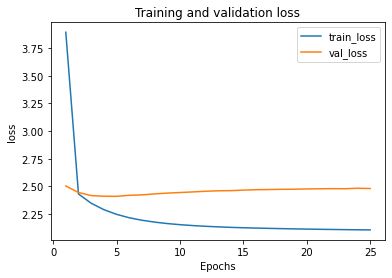

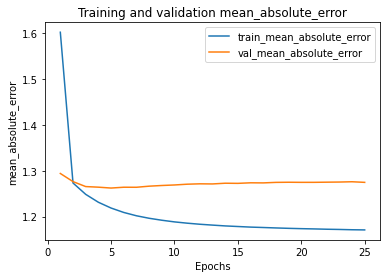

In [18]:


# ---------------------------------------------------------------------------------------------------------------------
# ---------------------------------------------------------------------------------------------------------------------
# TRAIN -> DEV Y TEST
# ---------------------------------------------------------------------------------------------------------------------
VALIDATION = True
model, n_epochs = entrenar(VALIDATION, K, max_epochs, tam_batch, learning_rate, peso_score, num_users, num_pelis,
                           dim_input_users, dim_input_pelis, X_train, X_train_dev, X_test, y_train, y_train_dev, y_test)



Epoch 1/24
1759/1759 [==============================] - 2s 949us/step - loss: 6.3994 - mean_absolute_error: 2.1257 1s - loss: 1

FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.
INFO:tensorflow:Assets written to: model/model_history_generos_reales2_log.csv/assets
Epoch 2/24
   1/1759 [..............................] - ETA: 2s - loss: 2.4759 - mean_absolute_error: 1.3195

/Users/antonio/miniforge3/envs/doctor/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '
/Users/antonio/miniforge3/envs/doctor/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:1397: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`layer.updates` will be removed in a future version. '


1759/1759 [==============================] - 2s 1ms/step - loss: 2.4081 - mean_absolute_error: 1.2660

FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.
INFO:tensorflow:Assets written to: model/model_history_generos_reales2_log.csv/assets
Epoch 3/24
1759/1759 [==============================] - 2s 1ms/step - loss: 2.3327 - mean_absolute_error: 1.2437

FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.
INFO:tensorflow:Assets written to: model/model_history_generos_reales2_log.csv/assets
Epoch 4/24
1759/1759 [==============================] - 2s 1ms/step - loss: 2.2675 - mean_absolute_error: 1.2245

FOR DEVS: If you are overwriting _tracking_metadata

INFO:tensorflow:Assets written to: model/model_history_generos_reales2_log.csv/assets
Epoch 10/24
1759/1759 [==============================] - 2s 1ms/step - loss: 2.1414 - mean_absolute_error: 1.1852

FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.
INFO:tensorflow:Assets written to: model/model_history_generos_reales2_log.csv/assets
Epoch 11/24
1759/1759 [==============================] - 2s 1ms/step - loss: 2.1271 - mean_absolute_error: 1.1805

FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.
INFO:tensorflow:Assets written to: model/model_history_generos_reales2_log.csv/assets
Epoch 12/24
1759/1759 [==============================] - 2s 1ms/st

INFO:tensorflow:Assets written to: model/model_history_generos_reales2_log.csv/assets
Epoch 18/24
1759/1759 [==============================] - 2s 1ms/step - loss: 2.1055 - mean_absolute_error: 1.1725

FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.
INFO:tensorflow:Assets written to: model/model_history_generos_reales2_log.csv/assets
Epoch 19/24
1759/1759 [==============================] - 2s 1ms/step - loss: 2.1019 - mean_absolute_error: 1.1719

FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.
INFO:tensorflow:Assets written to: model/model_history_generos_reales2_log.csv/assets
Epoch 20/24
1759/1759 [==============================] - 2s 1ms/st

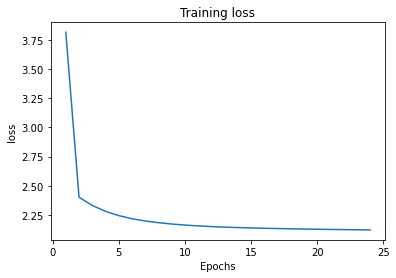

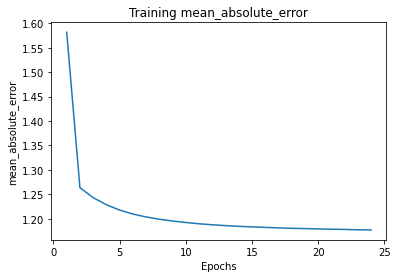

hiperparámetros: K=32, batch_size=512, learning_rate=0.001000, peso_score=0.50
FIN


In [19]:

# ---------------------------------------------------------------------------------------------------------------------
# ---------------------------------------------------------------------------------------------------------------------
# TRAIN+DEV -> TEST
# ---------------------------------------------------------------------------------------------------------------------
VALIDATION = False
model, prediction, usr_emb_genres = entrenar(VALIDATION, K, n_epochs, tam_batch, learning_rate, peso_score, num_users,
                                        num_pelis, dim_input_users, dim_input_pelis,
                                        X_train, X_train_dev, X_test, y_train, y_train_dev, y_test)


# ---------------------------------------------------------------------------------------------------------------------
# ---------------------------------------------------------------------------------------------------------------------
# ---------------------------------------------------------------------------------------------------------------------

print('hiperparámetros: K=%d, batch_size=%d, learning_rate=%f, peso_score=%.2f' % (K, tam_batch, learning_rate,
                                                                                   peso_score))
print("FIN")